In this tutorial, you will learn how to authenticate with the ASDC data archive and obtain access to the data stored in Amazon S3 buckets. This will enable you to seamlessly perform operations such as listing, copying, and retrieving data from the ASDC archive using your preferred Amazon methods, such as Python boto3, the Amazon SDK, or AWS CLI.

Note: Direct S3 access is exclusively accessible to users operating within the AWS environment, specifically in the us-west-2 region. For all other access, it is required to make HTTP requests for ASDC data.

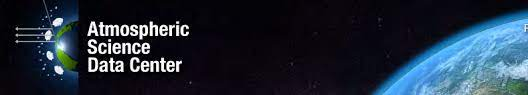


Imports necessary modules such as netrc, Popen, system, getpass, and os for a tutorial on achieving direct S3 access. The tutorial covers authentication with the ASDC data archive, utilizing Amazon S3 buckets, and will involve processes like handling credentials and system commands.

In [34]:
from netrc import netrc
from subprocess import Popen
from platform import system
from getpass import getpass
import os  # Direct S3 Access tutorial

In [35]:
urs = "urs.earthdata.nasa.gov"  # Earthdata URL endpoint for authentication
prompts = ["Enter NASA Earthdata Login Username: ", "Enter NASA Earthdata Login Password: "]

# Determine the OS (Windows machines usually use an '_netrc' file)
netrc_name = "_netrc" if system() == "Windows" else ".netrc"

# Determine if netrc file exists, and if so, if it includes NASA Earthdata Login Credentials
try:
    netrcDir = os.path.expanduser(f"~/{netrc_name}")
    netrc(netrcDir).authenticators(urs)[0]

# Below, create a netrc file and prompt user for NASA Earthdata Login Username and Password
except FileNotFoundError:
    homeDir = os.path.expanduser("~")
    Popen(
        "touch {0}{2} | echo machine {1} >> {0}{2}".format(homeDir + os.sep, urs, netrc_name),
        shell=True,
    )
    Popen(
        "echo login {} >> {}{}".format(getpass(prompt=prompts[0]), homeDir + os.sep, netrc_name),
        shell=True,
    )
    Popen(
        "echo 'password {} '>> {}{}".format(
            getpass(prompt=prompts[1]), homeDir + os.sep, netrc_name
        ),
        shell=True,
    )
    # Set restrictive permissions
    Popen("chmod 0600 {0}{1}".format(homeDir + os.sep, netrc_name), shell=True)

    # Determine OS and edit netrc file if it exists but is not set up for NASA Earthdata Login
except TypeError:
    homeDir = os.path.expanduser("~")
    Popen("echo machine {1} >> {0}{2}".format(homeDir + os.sep, urs, netrc_name), shell=True)
    Popen(
        "echo login {} >> {}{}".format(getpass(prompt=prompts[0]), homeDir + os.sep, netrc_name),
        shell=True,
    )
    Popen(
        "echo 'password {} '>> {}{}".format(
            getpass(prompt=prompts[1]), homeDir + os.sep, netrc_name
        ),
        shell=True,
    )

In [36]:
#!ls -al ~/

In [37]:
import boto3
import requests
import xarray as xr

%matplotlib inline

## Get Temporary AWS Credentials for Access

Note: AWS Credentials will expire after one hour

S3 serves as an 'object store' on AWS for cloud processing. To enable direct S3 access, temporary credentials provided by NASA must be passed to AWS, facilitating interaction with S3 objects within applicable Earthdata Cloud buckets. It's important to note that these temporary credentials remain valid for only one hour. To obtain them, a netrc file is required. Utilize NASA Earthdata Authentication to generate a netrc file in your home directory.  Use the [NASA Earthdata Authentication](https://github.com/NASA-Openscapes/2021-Cloud-Hackathon/blob/main/tutorials/04_NASA_Earthdata_Authentication.ipynb) to create a netrc file in your home directory. (Note: A NASA Earthdata Login is essential for accessing data from the NASA Earthdata system. Register and manage your Earthdata Login account at https://urs.earthdata.nasa.gov. This account is free to create and requires only a brief setup time.)

While the presented credentials are for ASDC, distinct credentials are necessary for accessing data from other NASA DAACs.

In [38]:
s3_cred_endpoint = "https://data.asdc.earthdata.nasa.gov/s3credentials"

Create a function to make a request to an endpoint for temporary credentials.

In [39]:
def get_temp_creds():
    temp_creds_url = s3_cred_endpoint
    return requests.get(temp_creds_url).json()

In [40]:
temp_creds_req = get_temp_creds()
# temp_creds_req                      # !!! Removing the # on this line will print your temporary S3 credentials.

### List all datasets available using boto3

In [41]:
s3_client = boto3.client(
    "s3",
    aws_access_key_id=temp_creds_req["accessKeyId"],
    aws_secret_access_key=temp_creds_req["secretAccessKey"],
    aws_session_token=temp_creds_req["sessionToken"],
)

In [9]:
# If you want to view a list of the S3 bucket content

# s3_client.list_objects(Bucket="asdc-prod-protected", Prefix="TEMPO/TEMPO_O3TOT_L3_V01/")
# s3_client.list_objects(Bucket="asdc-prod-protected", Prefix="TEMPO/TEMPO_HCHO-PROXY_L2_V01/")

### Download a specific file within the cloud, open and plot a variable from it

In [42]:
s3_client.download_file(
    "asdc-prod-protected",
    "TEMPO/TEMPO_O3TOT_L3_V01/2023.10.17/TEMPO_O3TOT_L3_V01_20231017T235411Z_S012.nc",
    "TEMPO_O3TOT_L3_V01_20231017T111336Z_S001.nc",
)

In [43]:
results = s3_client.download_file(
    "asdc-prod-protected",
    "TEMPO/TEMPO_O3TOT_L3_V01/2023.10.17/TEMPO_O3TOT_L3_V01_20231017T235411Z_S012.nc",
    "TEMPO_O3TOT_L3_V01_20231017T111336Z_S001.nc",
)

In [44]:
ds = xr.open_dataset("TEMPO_O3TOT_L3_V01_20231017T111336Z_S001.nc")
ds

<xarray.Dataset>
Dimensions:    (longitude: 2611, latitude: 940, time: 1)
Coordinates:
  * longitude  (longitude) float32 -155.0 -154.9 -154.9 ... -24.58 -24.52 -24.48
  * latitude   (latitude) float32 17.02 17.08 17.12 17.17 ... 63.88 63.92 63.97
  * time       (time) datetime64[ns] 2023-10-17T23:54:29.148480768
Data variables:
    weight     (latitude, longitude) float32 ...
Attributes: (12/39)
    history:                          2023-10-18T03:19:29Z: L2_regrid -v /tem...
    scan_num:                         12
    time_coverage_start:              2023-10-17T23:54:11Z
    time_coverage_end:                2023-10-18T00:33:57Z
    time_coverage_start_since_epoch:  1381622069.148481
    time_coverage_end_since_epoch:    1381624455.7362878
    ...                               ...
    title:                            TEMPO Level 3 total ozone product
    collection_shortname:             TEMPO_O3TOT_L3
    collection_version:               1
    keywords:                         EARTH SCIENCE>ATMOSPHERE>ATMOSPHERIC CH...
    summary:                          Total ozone Level 3 files provide ozone...
    coremetadata:                     \nGROUP                  = INVENTORYMET...

In [45]:
# print(ds.keys())


In [46]:
# all_results_stored = [f.result() for f in ds]
# print(f"Number of result files: {len(all_results_stored)}")

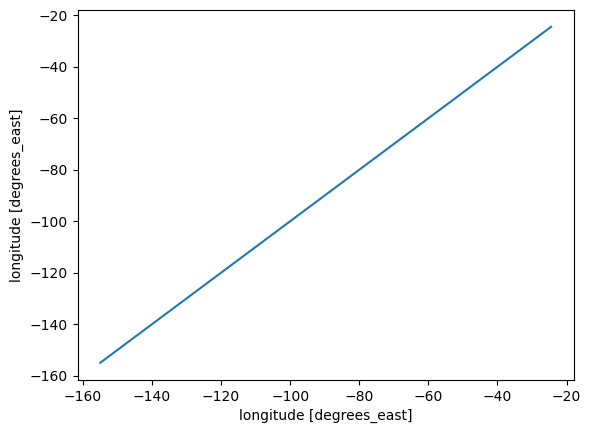

In [47]:
ds.longitude.plot()

### Set up an `s3fs` session for Direct Access without downloading within the cloud
`s3fs` sessions serve the purpose of facilitating authenticated access to S3 buckets, enabling conventional file-system style operations. In the following steps, we establish a session by providing the temporary credentials obtained from our credentials endpoint, and subsequently identify the S3 paths leading to the desired data.

In [48]:
import s3fs
import os

os.environ["AWS_ACCESS_KEY_ID"] = temp_creds_req["accessKeyId"]
os.environ["AWS_SECRET_ACCESS_KEY"] = temp_creds_req["secretAccessKey"]
os.environ["AWS_SESSION_TOKEN"] = temp_creds_req["sessionToken"]

s3 = s3fs.S3FileSystem(anon=False)

s3path = "s3://asdc-prod-protected/TEMPO/TEMPO_O3TOT_L3_V01/2023.11.17/*.nc"
remote_files = s3.glob(s3path)

In [49]:
import os

current_directory = os.getcwd()
print("Current Directory:", current_directory)

Current Directory: /home/jovyan


This code utilizes the s3fs library to establish authenticated access to an S3 bucket and download files matching a specified pattern. Key steps include setting AWS credentials, initializing the S3 filesystem, defining the S3 path pattern, listing matching files, and downloading them to a specified local directory. The script concludes by printing the number of downloaded files and the local directory path.

In [50]:
import s3fs

# Set AWS credentials
os.environ["AWS_ACCESS_KEY_ID"] = temp_creds_req["accessKeyId"]
os.environ["AWS_SECRET_ACCESS_KEY"] = temp_creds_req["secretAccessKey"]
os.environ["AWS_SESSION_TOKEN"] = temp_creds_req["sessionToken"]

# Initialize S3 filesystem
s3 = s3fs.S3FileSystem(anon=False)

# Specify the S3 path pattern
s3path = "s3://asdc-prod-protected/TEMPO/TEMPO_O3TOT_L3_V01/2023.11.17/*.nc"
# List matching files
remote_files = s3.glob(s3path)

# Download files
local_directory = "/home/jovyan"  # Specify your local directory here

for remote_file in remote_files:
    remote_file_name = remote_file.split("/")[-1]  # Extract file name from the S3 path
    local_file_path = os.path.join(local_directory, remote_file_name)  # Local file path
    with s3.open(remote_file, "rb") as remote_data:
        with open(local_file_path, "wb") as local_file:
            local_file.write(remote_data.read())

print(f"Downloaded {len(remote_files)} files to {local_directory}")

Downloaded 15 files to /home/jovyan


In [51]:
# 12 Files list
remote_files

['asdc-prod-protected/TEMPO/TEMPO_O3TOT_L3_V01/2023.11.17/TEMPO_O3TOT_L3_V01_20231117T115109Z_S001.nc',
 'asdc-prod-protected/TEMPO/TEMPO_O3TOT_L3_V01/2023.11.17/TEMPO_O3TOT_L3_V01_20231117T123114Z_S002.nc',
 'asdc-prod-protected/TEMPO/TEMPO_O3TOT_L3_V01/2023.11.17/TEMPO_O3TOT_L3_V01_20231117T131119Z_S003.nc',
 'asdc-prod-protected/TEMPO/TEMPO_O3TOT_L3_V01/2023.11.17/TEMPO_O3TOT_L3_V01_20231117T135124Z_S004.nc',
 'asdc-prod-protected/TEMPO/TEMPO_O3TOT_L3_V01/2023.11.17/TEMPO_O3TOT_L3_V01_20231117T143129Z_S005.nc',
 'asdc-prod-protected/TEMPO/TEMPO_O3TOT_L3_V01/2023.11.17/TEMPO_O3TOT_L3_V01_20231117T153129Z_S006.nc',
 'asdc-prod-protected/TEMPO/TEMPO_O3TOT_L3_V01/2023.11.17/TEMPO_O3TOT_L3_V01_20231117T163129Z_S007.nc',
 'asdc-prod-protected/TEMPO/TEMPO_O3TOT_L3_V01/2023.11.17/TEMPO_O3TOT_L3_V01_20231117T173129Z_S008.nc',
 'asdc-prod-protected/TEMPO/TEMPO_O3TOT_L3_V01/2023.11.17/TEMPO_O3TOT_L3_V01_20231117T183129Z_S009.nc',
 'asdc-prod-protected/TEMPO/TEMPO_O3TOT_L3_V01/2023.11.17/TEMPO_

In [68]:
ds = xr.open_dataset("TEMPO_O3TOT_L3_V01_20231117T233144Z_S015.nc")
ds

<xarray.Dataset>
Dimensions:    (longitude: 2611, latitude: 940, time: 1)
Coordinates:
  * longitude  (longitude) float32 -155.0 -154.9 -154.9 ... -24.58 -24.52 -24.48
  * latitude   (latitude) float32 17.02 17.08 17.12 17.17 ... 63.88 63.92 63.97
  * time       (time) datetime64[ns] 2023-11-17T23:32:02.147030016
Data variables:
    weight     (latitude, longitude) float32 ...
Attributes: (12/39)
    history:                          2023-11-18T02:58:59Z: L2_regrid -v /tem...
    scan_num:                         15
    time_coverage_start:              2023-11-17T23:31:44Z
    time_coverage_end:                2023-11-18T00:11:30Z
    time_coverage_start_since_epoch:  1384299122.14703
    time_coverage_end_since_epoch:    1384301508.7362707
    ...                               ...
    title:                            TEMPO Level 3 total ozone product
    collection_shortname:             TEMPO_O3TOT_L3
    collection_version:               1
    keywords:                         EARTH SCIENCE>ATMOSPHERE>ATMOSPHERIC CH...
    summary:                          Total ozone Level 3 files provide ozone...
    coremetadata:                     \nGROUP                  = INVENTORYMET...

In [52]:
pip install pycno     #Required library

Note: you may need to restart the kernel to use updated packages.


In [53]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

This Jupyter notebook code processes TEMPO ozone data stored in NetCDF files, creating individual Cartopy plots for each granule. Key steps include reading the data, checking for data validity, and generating scatter plots with ozone concentrations. The resulting plots are saved as PNG files in the specified directory. The script provides informative messages about the number of granules found and their paths, ensuring a user-friendly experience.

The following code utilizes libraries like glob, os, sys, numpy, netCDF4, and matplotlib to process TEMPO ozone data. It reads granule files, checks data integrity, and generates Cartopy plots for each granule. The script is currently set to process the first granule only and contains commented-out sections that may require adjustment for specific use cases.

In [70]:
# Generates png files for timelapse. This steps needs powerful machine with more than 32GB RAM
import glob
import os
import sys
import netCDF4 as nc
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


def read_TEMPO_O3TOT_L3(fn):
    ds = nc.Dataset(fn)
    lat = np.array(ds.variables["latitude"])
    lon = np.array(ds.variables["longitude"])
    prod = ds.groups["product"]
    o3var = prod.variables["column_amount_o3"]
    fv = o3var.getncattr("_FillValue")
    o3tot = np.array(o3var)
    return lat, lon, o3tot, fv


nlat0 = 940
nlon0 = 2611
path_L3_O3 = "/home/jovyan/"

year = "2023"
month = "11"
granules = glob.glob(path_L3_O3 + "/TEMPO_O3TOT_L3_V01*.nc")


# granules = os.listdir(path_L3_O3)

granules.sort()
ng = len(granules)
if ng < 1:
    print("no granules were found for yyyymm " + year + month + ", program terminated")
    sys.exit()
elif ng == 1:
    print("one granule was found for yyyymm " + year + month)
    print(granules[0])
else:
    print(ng, " granules were found for yyyymm " + year + month + ", here are the first few:")
    [
        print(granule) for granule in granules[0 : min(ng, 20)]
    ]  ########################change month here too


for granule in granules:
    Tind = granule.rfind("T")
    year = granule[Tind - 8 : Tind - 4]
    month = granule[Tind - 4 : Tind - 2]
    latc, lonc, o3totc, fv = read_TEMPO_O3TOT_L3(os.path.join(path_L3_O3, granule))

    if latc.shape[0] != nlat0 or lonc.shape[0] != nlon0 or o3totc.shape[0:2] != (nlat0, nlon0):
        print(f"Invalid shape for granule {granule}, skipping...")
        continue

    lat = np.empty([nlat0, nlon0], dtype=float)
    lon = np.empty([nlat0, nlon0], dtype=float)
    for ilon in range(nlon0):
        lat[0:nlat0, ilon] = latc[0:nlat0]
    for ilat in range(nlat0):
        lon[ilat, 0:nlon0] = lonc[0:nlon0]

    o3totc[o3totc == fv] = np.nan
    o3totc = np.ma.masked_where(np.isnan(o3totc), o3totc)

    fig = plt.figure(figsize=(12, 9.5), dpi=600)
    proj = ccrs.LambertConformal(
        central_longitude=-96.0,
        central_latitude=39.0,
        false_easting=0.0,
        false_northing=0.0,
        standard_parallels=(33, 45),
        globe=None,
        cutoff=10,
    )
    ax1 = fig.add_subplot(111, projection=proj)
    im1 = ax1.scatter(
        lon,
        lat,
        c=o3totc,
        s=1,
        cmap=plt.cm.jet,
        vmin=200.0,
        vmax=500.0,
        transform=ccrs.PlateCarree(),
    )
    ax1.coastlines(resolution="50m", color="black", linewidth=1)
    gl = ax1.gridlines()
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    cb1 = plt.colorbar(im1, ticks=[200, 300, 400, 500, 600], fraction=0.022, pad=0.01)
    cb1.set_label("DU", fontsize=10)
    ax1.set_title("Ozone", size=10)
    plt.savefig(os.path.join(path_L3_O3, granule[:-3] + ".png"), dpi=600)
    plt.close()

print("PNG files generated for all granules.")

16  granules were found for yyyymm 202311, here are the first few:
/home/jovyan/TEMPO_O3TOT_L3_V01_20231017T111336Z_S001.nc
/home/jovyan/TEMPO_O3TOT_L3_V01_20231117T115109Z_S001.nc
/home/jovyan/TEMPO_O3TOT_L3_V01_20231117T123114Z_S002.nc
/home/jovyan/TEMPO_O3TOT_L3_V01_20231117T131119Z_S003.nc
/home/jovyan/TEMPO_O3TOT_L3_V01_20231117T135124Z_S004.nc
/home/jovyan/TEMPO_O3TOT_L3_V01_20231117T143129Z_S005.nc
/home/jovyan/TEMPO_O3TOT_L3_V01_20231117T153129Z_S006.nc
/home/jovyan/TEMPO_O3TOT_L3_V01_20231117T163129Z_S007.nc
/home/jovyan/TEMPO_O3TOT_L3_V01_20231117T173129Z_S008.nc
/home/jovyan/TEMPO_O3TOT_L3_V01_20231117T183129Z_S009.nc
/home/jovyan/TEMPO_O3TOT_L3_V01_20231117T193129Z_S010.nc
/home/jovyan/TEMPO_O3TOT_L3_V01_20231117T203129Z_S011.nc
/home/jovyan/TEMPO_O3TOT_L3_V01_20231117T213129Z_S012.nc
/home/jovyan/TEMPO_O3TOT_L3_V01_20231117T221134Z_S013.nc
/home/jovyan/TEMPO_O3TOT_L3_V01_20231117T225139Z_S014.nc
/home/jovyan/TEMPO_O3TOT_L3_V01_20231117T233144Z_S015.nc
PNG files generated f

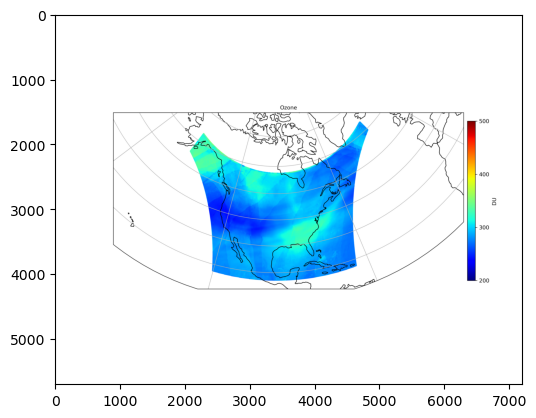

In [71]:
import os
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Directory containing PNG files
png_directory = "/home/jovyan/"

# Get list of PNG files in the directory
png_files = sorted([file for file in os.listdir(png_directory) if file.endswith(".png")])


# Function to update the animation frames
def update(frame):
    img_path = os.path.join(png_directory, png_files[frame])
    img.set_data(plt.imread(img_path))
    return (img,)


# Create a figure and axis
fig, ax = plt.subplots()

# Load the first image to get the dimensions
first_img_path = os.path.join(png_directory, png_files[0])
img = ax.imshow(plt.imread(first_img_path), animated=True)

# Customize the plot if needed (titles, labels, etc.)
# ax.set_title('Title')
# ax.set_xlabel('X Label')
# ax.set_ylabel('Y Label')

# Create the animation
animation = FuncAnimation(fig, update, frames=len(png_files), interval=200, blit=True)

# If you want to save the animation as a video file
animation.save("output_animation.mp4", writer="ffmpeg")

plt.show()

In [2]:
# from IPython.display import display, Image

# # Path to the GIF file
# gif_path = '/home/jovyan/Ozone.gif'

# # Display the GIF in the Jupyter Notebook
# with open(gif_path, 'rb') as file:
#     display(Image(file.read()))

In [1]:
# # Specify the file path
# gif_path = '/home/jovyan/Ozone.gif'

# # Create an empty file
# with open(gif_path, 'w') as file:
#     pass  # This block is empty, so the file will be created with no content

# # Now you can proceed with your code to display the GIF
# with open(gif_path, 'rb') as file:
#     display(Image(file.read()))
